## Import packages

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import graphviz 
import pydotplus
import sklearn.tree as tree
from pydotplus import graph_from_dot_data
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Load data

In [2]:
path_to_data = "https://gitlab.com/slud00/datax/-/raw/main/data/"
data_mushrooms_name = "mushrooms_vse.csv" 

data_mushrooms_raw = pd.read_csv(path_to_data + data_mushrooms_name)

### Explore data - head, shape, dtypes

In [3]:
data_mushrooms_raw.head()

class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

In [4]:
data_mushrooms_raw.shape

(8131, 23)

In [5]:
data_mushrooms_raw.dtypes # all variables are categorical

class                       object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises                     object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

In [6]:
data_mushrooms_raw.describe(include="all")

class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count   8131      8131        8131      8131    8131  8131            8131   
unique     2         6           4        10       2     9               2   
top        e         x           y         n       f     n               f   
freq    4211      3663        3244      2288    4748  3528            7921   

       gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
count          8131      8131       8131  ...                     8131   
unique            2         2         12  ...                        4   
top               c         b          b  ...                        s   
freq           6819      5615       1728  ...                     4943   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8131                   8131      8131       8131   
unique                      9                      9         1          4   
top                         w                      w         p          w   
freq                     4471                   4391      8131       7931   

       ring-number ring-type spore-print-color population habitat  
count         8131      8131              8131       8131    8131  
unique           3         5                 9          6       7  
top              o         p                 w          v       d  
freq          7495      3975              2388       4044    3148  

[4 rows x 23 columns]

In [7]:
# no missing values
data_mushrooms_raw.isna().sum(axis = 0)

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [8]:
# we are also interested in number of unique rows
data_mushrooms_copy = data_mushrooms_raw.copy()
data_mushrooms_copy["concat_levels"] = data_mushrooms_copy.apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_mushrooms_copy["concat_levels"].nunique()

8125

In [9]:
data_mushrooms_copy["concat_levels"].value_counts().head()

e_x_s_y_t_a_f_c_b_k_e_c_s_s_w_w_p_w_o_p_n_n_g    4
p_x_s_n_t_p_f_c_n_p_e_e_s_s_w_w_p_w_o_p_n_v_g    4
p_f_y_y_f_f_f_c_b_h_e_b_k_k_p_n_p_w_o_l_h_v_p    1
p_f_s_g_t_f_f_c_b_w_t_b_f_s_w_w_p_w_o_p_h_s_g    1
p_f_s_b_t_f_f_c_b_h_t_b_s_f_w_w_p_w_o_p_h_s_u    1
Name: concat_levels, dtype: int64

### Replace labels with full labels for each variable

In [10]:
full_labels_dict_name = "full_labels_dict.csv"

full_labels_dict = pd.read_csv(path_to_data + full_labels_dict_name) # on GitLab
full_labels_dict.head()

variable                                   full_labels_dict
0      classes                  {'e': 'edible', 'p': 'poisonous'}
1    cap-shape  {'b': 'bell', 'c': 'conical', 'x': 'convex', '...
2  cap-surface  {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly',...
3    cap-color  {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', '...
4      bruises                        {'t': 'bruises', 'f': 'no'}

In [11]:
def create_full_labels_df(df, full_labels_dict):
    df_full_labels = df.copy() 

    for i in range(df_full_labels.shape[1]):
        replace_dict = json.loads(full_labels_dict.iloc[i,1].replace("\'", "\""))
        keys, values = zip(*replace_dict.items())
        df_full_labels.iloc[:,i] = df_full_labels.iloc[:,i].replace(list(keys), list(values)).astype("category")
        
        
    return df_full_labels

In [12]:
data_mushrooms = create_full_labels_df(data_mushrooms_raw, full_labels_dict)
data_mushrooms.head()

class cap-shape cap-surface cap-color  bruises     odor  \
0  poisonous    convex      smooth     brown  bruises  pungent   
1     edible    convex      smooth    yellow  bruises   almond   
2     edible      bell      smooth     white  bruises    anise   
3  poisonous    convex       scaly     white  bruises  pungent   
4     edible    convex      smooth      gray       no     none   

  gill-attachment gill-spacing gill-size gill-color  ...  \
0            free        close    narrow      black  ...   
1            free        close     broad      black  ...   
2            free        close     broad      brown  ...   
3            free        close    narrow      brown  ...   
4            free      crowded     broad      black  ...   

  stalk-surface-below-ring stalk-color-above-ring stalk-color-below-ring  \
0                   smooth                  white                  white   
1                   smooth                  white                  white   
2                   smooth                  white                  white   
3                   smooth                  white                  white   
4                   smooth                  white                  white   

  veil-type veil-color ring-number   ring-type spore-print-color population  \
0   partial      white         one     pendant             black  scattered   
1   partial      white         one     pendant             brown   numerous   
2   partial      white         one     pendant             brown   numerous   
3   partial      white         one     pendant             black  scattered   
4   partial      white         one  evanescent             brown   abundant   

   habitat  
0    urban  
1  grasses  
2  meadows  
3    urban  
4  grasses  

[5 rows x 23 columns]

In [13]:
data_mushrooms.describe(include="all")

class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count     8131      8131        8131      8131    8131  8131            8131   
unique       2         6           4        10       2     9               2   
top     edible    convex       scaly     brown      no  none            free   
freq      4211      3663        3244      2288    4748  3528            7921   

       gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
count          8131      8131       8131  ...                     8131   
unique            2         2         12  ...                        4   
top           close     broad       buff  ...                   smooth   
freq           6819      5615       1728  ...                     4943   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8131                   8131      8131       8131   
unique                      9                      9         1          4   
top                     white                  white   partial      white   
freq                     4471                   4391      8131       7931   

       ring-number ring-type spore-print-color population habitat  
count         8131      8131              8131       8131    8131  
unique           3         5                 9          6       7  
top            one   pendant             white    several   woods  
freq          7495      3975              2388       4044    3148  

[4 rows x 23 columns]

In [14]:
data_mushrooms.dtypes

class                       category
cap-shape                   category
cap-surface                 category
cap-color                   category
bruises                     category
odor                        category
gill-attachment             category
gill-spacing                category
gill-size                   category
gill-color                  category
stalk-shape                 category
stalk-root                  category
stalk-surface-above-ring    category
stalk-surface-below-ring    category
stalk-color-above-ring      category
stalk-color-below-ring      category
veil-type                   category
veil-color                  category
ring-number                 category
ring-type                   category
spore-print-color           category
population                  category
habitat                     category
dtype: object

### Explore the variables one by one with respect to class

In [15]:
def plot_one_variable(var_ix, save = False):
    crosstab = pd.crosstab(data_mushrooms.iloc[:,var_ix], data_mushrooms.iloc[:,0])
    crosstab["total"] = crosstab.sum(axis = 1)
    crosstab = crosstab.sort_values(by = "total", ascending = False)
    crosstab["Relative edibles"] = crosstab.iloc[:,0]/crosstab["total"]*100
    crosstab["Relative poisonous"] = crosstab.iloc[:,1]/crosstab["total"]*100

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].bar(x = crosstab.index, height = crosstab.loc[:,"total"])
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Histogram of {data_mushrooms.columns[var_ix]}')

    axes[1].bar(x = crosstab.index, height = crosstab.iloc[:,3])
    axes[1].bar(x = crosstab.index, height = crosstab.iloc[:,4], bottom=crosstab.iloc[:,3])
    axes[1].set_ylabel('Relative count (%)')
    axes[1].set_title(f'Relative counts of {data_mushrooms.columns[var_ix]} w.r.t. class')
    axes[1].legend(["Edibles","Poisonous"])
    
    if crosstab.shape[0]>6:
        axes[0].set_xticks(list(range(crosstab.shape[0])))
        axes[0].set_xticklabels(crosstab.index, rotation=45)
        axes[1].set_xticks(list(range(crosstab.shape[0])))
        axes[1].set_xticklabels(crosstab.index, rotation=45)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(f"plots/plot_{var_ix}.pdf")
        plt.close()
    else:
        plt.show()

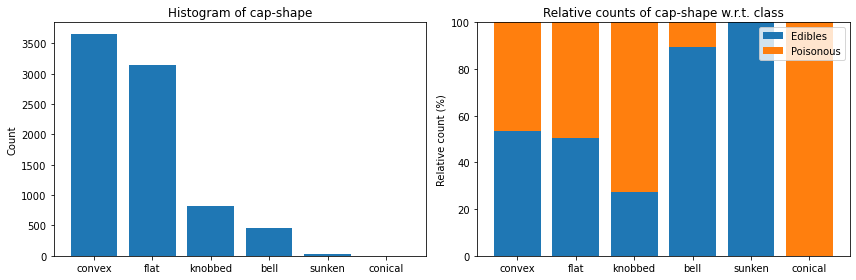

In [16]:
# plot a variable
plot_one_variable(1)

In [17]:
# save all plots
#for i in range(1,data_mushrooms.shape[1]):
#    plot_one_variable(i, save = True)

# Prepare data for modelling

## Get dummies

In [18]:
x = pd.get_dummies(data_mushrooms.drop("class", axis = 1))
y = data_mushrooms[["class"]]

In [19]:
x.shape

(8131, 118)

## Training and test data

In [20]:
# Split the dataset into training and testing part and assign response and explanatroy variables
seed = 300
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state = seed)

# Modelling

## Decision tree

### Default settings

In [21]:
# Instantiate decision tree classifier and assign it to 'clf'
clf = tree.DecisionTreeClassifier()

In [22]:
# Fit 'clf' to the training set
clf.fit(x_train, y_train)

DecisionTreeClassifier()

In [23]:
clf.feature_importances_

array([0.00000000e+00, 6.14073676e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.83950989e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.06994855e-02, 2.43564654e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.21560680e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.27708796e-03,
       3.28070793e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.79642116e-01, 0.00000000e+00, 0.00000000e+00,
      

In [24]:
# The most important features
df_import = pd.DataFrame(x_train.columns, clf.feature_importances_).reset_index().sort_values(by = "index", 
                                                                                              ascending = False)
df_import.columns = ["feature importance", "feature"]
df_import = df_import[["feature", "feature importance"]]

df_import

feature  feature importance
28                 odor_none            0.621561
53           stalk-root_club            0.179642
56         stalk-root_rooted            0.080125
100  spore-print-color_green            0.032316
23                odor_anise            0.024356
..                       ...                 ...
38          gill-color_brown            0.000000
37          gill-color_black            0.000000
34      gill-spacing_crowded            0.000000
33        gill-spacing_close            0.000000
117            habitat_woods            0.000000

[118 rows x 2 columns]

In [25]:
# save the most important into a table
#df_import.iloc[0:9,:].round(2).to_excel("feature_imporance_table.xlsx")

In [26]:
# Make predictions on the test data
y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

In [27]:
# Calculate accuracy
print(f"Accuracy on training dataset: {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy on testing dataset: {accuracy_score(y_test, y_pred_test)}")

Accuracy on training dataset: 1.0
Accuracy on testing dataset: 1.0


In [28]:
# Metrics table
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

      edible       1.00      1.00      1.00       853
   poisonous       1.00      1.00      1.00       774

    accuracy                           1.00      1627
   macro avg       1.00      1.00      1.00      1627
weighted avg       1.00      1.00      1.00      1627



/Users/marek/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


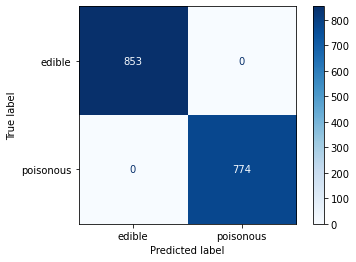

In [32]:
# Confusion matrix
confusion_matrix(y_test, y_pred_test)

plot_confusion_matrix(clf, x_test, y_test, cmap=plt.cm.Blues)
#plt.savefig("confusion_matrix.pdf") save conf. matrix
plt.show()

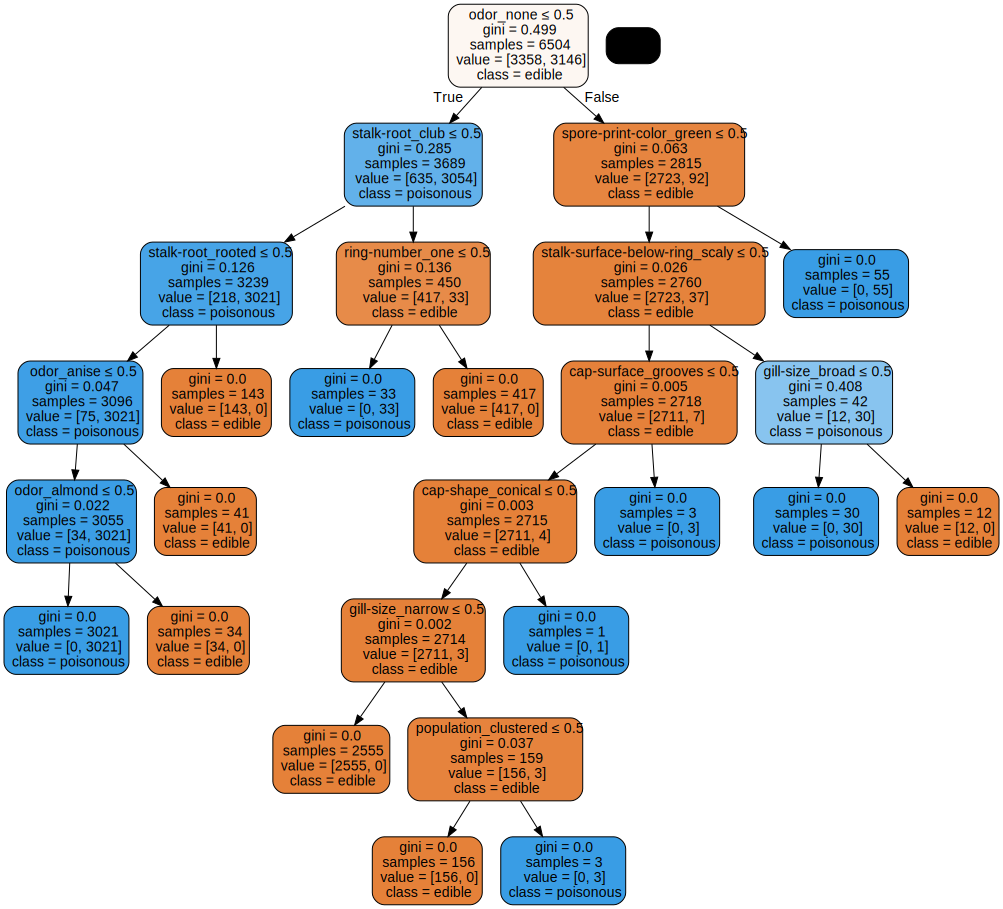

In [33]:
# Plot the tree
data = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True, 
                            special_characters=True, 
                            feature_names = x.columns, class_names = ["edible", "poisonous"])
pydot_graph = pydotplus.graph_from_dot_data(data)
#pydot_graph.write_png('original_tree.pdf') save tree
#pydot_graph.set_size('"11!"')
#pydot_graph.write_png('resized_tree.pdf')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

### Grid search

In [53]:
params = {"criterion": ["gini"], "max_depth": [2,4,6,8], "min_samples_split": [2], 
          "min_samples_leaf": [1], "max_features": [5, 10, 15, 20], "random_state": [300]}

In [54]:
grid = GridSearchCV(estimator = clf,
                    param_grid = params)

In [55]:
grid.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [2, 4, 6, 8],
                         'max_features': [5, 10, 15, 20],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'random_state': [300]})

In [56]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=8, max_features=20, random_state=300)

In [57]:
grid.best_score_

1.0

## Random forest

In [58]:
forest_clf = RandomForestClassifier(random_state = seed)

In [59]:
forest_clf.fit(x_train, np.ravel(y_train))

RandomForestClassifier(random_state=300)

In [60]:
forest_clf.feature_importances_

array([1.26795680e-03, 1.09842225e-04, 1.15923652e-03, 9.65596146e-04,
       4.58543700e-04, 3.83617036e-04, 3.53306534e-03, 1.60070241e-04,
       1.60923411e-03, 3.36592680e-03, 1.04346730e-03, 1.78598367e-03,
       9.37915314e-04, 1.67543161e-03, 7.47971876e-05, 1.87516676e-03,
       1.27787157e-04, 2.17563711e-04, 2.64865795e-03, 2.72964281e-03,
       2.34233163e-02, 2.59140041e-02, 3.33689541e-03, 6.99888164e-03,
       8.11197909e-03, 3.23505003e-03, 6.71119590e-02, 6.04219744e-04,
       1.12179817e-01, 1.39211831e-02, 2.49669580e-03, 1.46185578e-03,
       1.12371062e-03, 2.26978852e-02, 1.52143912e-02, 6.19069492e-02,
       7.00364998e-02, 1.03505880e-04, 7.19571565e-04, 3.27455898e-02,
       1.22806557e-03, 4.63808707e-04, 1.35385046e-03, 5.49550186e-08,
       2.51923968e-04, 9.51271174e-04, 5.83962412e-08, 1.01575830e-03,
       3.73485143e-04, 0.00000000e+00, 8.44947772e-03, 1.45492498e-02,
       1.66482561e-02, 4.30031578e-03, 1.17151629e-02, 5.99342379e-03,
      

In [61]:
forest_df_import = pd.DataFrame(x_train.columns, forest_clf.feature_importances_).reset_index().sort_values(by = "index", 
                                                                                              ascending = False)
forest_df_import.columns = ["feature importance", "feature"]
forest_df_import = forest_df_import[["feature", "feature importance"]]

forest_df_import

feature  feature importance
28                        odor_none            0.112180
36                 gill-size_narrow            0.070036
26                        odor_foul            0.067112
35                  gill-size_broad            0.061907
59   stalk-surface-above-ring_silky            0.061076
..                              ...                 ...
101        spore-print-color_orange            0.000000
84                 veil-color_brown            0.000000
83                veil-type_partial            0.000000
66      stalk-color-above-ring_buff            0.000000
49                   stalk-shape_Ee            0.000000

[118 rows x 2 columns]

In [62]:
accuracy_score(forest_clf.predict(x_test),y_test)

1.0

In [63]:
# number of estimators ensembled
len(forest_clf.estimators_)

100

# Save the models

In [64]:
#pickle.dump(clf,open("tree.pkl", "wb"))

In [65]:
#pickle.dump(forest_clf,open("random_forest.pkl", "wb"))

In [66]:
# load the models
#loaded_tree = pickle.load(open('tree.pkl', 'rb'))
#loaded_rf = pickle.load(open('random_forest.pkl', 'rb'))